In [269]:
import os
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
from ccdproc import cosmicray_lacosmic as lacosmic
import astroalign as aa
import sep
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Circle
import pandas as pd
import pickle
from kapteyn import kmpfit
import math

# %matplotlib inline

# rcParams['figure.figsize'] = [10., 8.]

In [270]:
lights = ["D:/AAO_data/light/" + i for i in os.listdir("D:/AAO_data/light/")]
flats = ["D:/AAO_data/flat/" + i for i in os.listdir("D:/AAO_data/flat/")]
biass = ["D:/AAO_data/bias/" + i for i in os.listdir("D:/AAO_data/bias/")]
darks = ["D:/AAO_data/dark/" + i for i in os.listdir("D:/AAO_data/dark/")]

In [3]:
lights_B = list(filter(lambda x: "_B_" in x, lights))
flats_B = list(filter(lambda x: "_B-" in x, flats))
lights_V = list(filter(lambda x: "_V_" in x, lights))
flats_V = list(filter(lambda x: "_V-" in x, flats))

In [ ]:
{"V_5min.fits": 'D:/AAO_data/light/20230417_M6_V_5min-001.fit', "V_3sec.fits": 'D:/AAO_data/light/20230428_M6_V_3sec-001.fit', "V_30sec.fits": 'D:/AAO_data/light/20230428_M6_V_30sec-001.fit'}
{"B_8min.fits": 'D:/AAO_data/light/20230429_M6_B_8min-002.fit', "B_4sec.fits": 'D:/AAO_data/light/20230502_M6_B_4sec-001.fit', "B_40sec.fits": 'D:/AAO_data/light/20230502_M6_B_40sec-001.fit'}

In [4]:
def reduce(lights, flats, biass, darks, expotime):

    n_bias = len(biass)
    master_bias = np.zeros(fits.open(lights[0])[0].data.shape)
    for i in biass:
        master_bias += fits.open(i)[0].data
        master_bias /= n_bias
    
    n_flat = len(flats)
    master_flat = np.zeros(fits.open(lights[0])[0].data.shape)
    for i in flats:
        master_flat += fits.open(i)[0].data
        master_flat /= n_flat
    
    K = fits.open(flats[0])[0].header["EXPTIME"] / np.mean(master_flat - master_bias)
    save_list = []
    
    for i in lights:
        s_time = i.split("_")[4].split("-")[0]
        if expotime == s_time:
            if "sec" in s_time:
                time = float(s_time.split("sec")[0])
            elif "min" in s_time:
                time = float(s_time.split("min")[0]) * 60
            else:
                pass

            n_dark = 0
            master_dark = np.zeros(fits.open(i)[0].data.shape)
            for j in darks:
                if s_time in j:
                    n_dark += 1
                    master_dark += fits.open(j)[0].data
                else:
                    pass
            master_dark /= n_dark
    
            reduced_image = ((fits.open(i)[0].data - master_dark) / time) / (K * (master_flat - master_bias) / fits.open(flats[0])[0].header["EXPTIME"])
    
            save_list.append(fits.ImageHDU(reduced_image))
        else:
            continue

    hdul = fits.HDUList(save_list)
      
    return hdul

In [5]:
def stacking(images):
    target, mask = lacosmic(images[0].data)
    target = target / len(images)

    for i in range(1, len(images)):
        source, mask = lacosmic(images[i].data)
        registered_image, footprint = aa.register(source, target, min_area = 9)
        target += registered_image / len(images)
  
    return target

In [6]:
def measure(data, gain, threshold, expotime, WCS_header, min_flux, max_flux):
    bkg = sep.Background(data)
    data_sub = data - bkg
    
    objects = sep.extract(data_sub, threshold, err = bkg.globalrms, gain = gain)
    objects = objects[objects["peak"] < max_flux]
    objects = objects[objects["peak"] > min_flux]

    kronrad, krflag = sep.kron_radius(data = data, x = objects["x"], y = objects["y"], a = objects["a"], b = objects["b"], theta = objects["theta"], r = 6.0)
    all_flux, all_fluxerr, all_flag = sep.sum_ellipse(data = data, x = objects["x"], y = objects["y"], a = objects["a"], b = objects["b"], theta = objects["theta"], r = 2.5 * kronrad, subpix = 1, err = bkg.globalrms, gain = gain)
    all_flag |= krflag

    photometry = []

    w = WCS(WCS_header)
    
    for i in range(0, len(objects)):
        sky = w.pixel_to_world(objects[i]["x"], objects[i]["y"])
        Ra = sky.ra.to(u.degree).value
        Dec = sky.dec.to(u.degree).value
        photometry.append({"x": objects[i]["x"], "y": objects[i]["y"], "r": kronrad[i], "flux": all_flux[i], "fluxerr": all_fluxerr[i], "RA": Ra, "DEC": Dec})

    return photometry

In [ ]:
def combine(data1, data2, seperation):
    data1_DEC = np.array([i["DEC"] for i in data1])
    data1_RA = np.array([i["RA"] for i in data1])
    data1_sky = SkyCoord(ra = data1_RA * u.degree, dec = data1_DEC * u.degree)
    combination = []

    n = 0
    for i in data2:
        n += 1
        if n % 50 == 0:
            print(str(n))
    
        data2_sky = SkyCoord(ra = i["RA"] * u.degree, dec = i["DEC"] * u.degree)
        idx, d2d, d3d = data2_sky.match_to_catalog_sky(data1_sky)
        if d2d.value < seperation:
            i["flux_V"] = i["flux"]
            i["flux_V_err"] = i["fluxerr"]
            i["flux_B"] = data1[idx]["flux"]
            i["flux_B_err"] = data1[idx]["fluxerr"]
            del i["flux"]
            del i["fluxerr"]
            combination.append(i)
        else:
            del i
    return combination

In [ ]:
def std_star_combination(data, std_star):
    catalog = []
    final = data
    for i in std_star:
        i.replace(" ", "").replace("\n", "")
        index = float(i.split(";")[0])
        RA = float(i.split(";")[2])
        DEC = float(i.split(";")[3])
        V_mag = float(i.split(";")[6])
        V_mag_err = float(i.split(";")[7])
        B_mag = float(i.split(";")[8])
        B_mag_err = float(i.split(";")[9])
        catalog.append({"index": int(index), "RA": RA, "DEC": DEC, "V_mag": V_mag, "V_mag_err": V_mag_err, "B_mag": B_mag, "B_mag_err": B_mag_err})
    
    for i in catalog:
        cat_sky = SkyCoord(ra = i["RA"] * u.degree, dec = i["DEC"] * u.degree)
        final_sky = SkyCoord(ra = final[i["index"]]["RA"] * u.degree, dec = final[i["index"]]["DEC"] * u.degree)
        sep = cat_sky.separation(final_sky)
        if sep.arcsecond < 1:
            final[i["index"]]["V_mag"] = i["V_mag"]
            final[i["index"]]["V_mag_err"] = i["V_mag_err"]
            final[i["index"]]["B_mag"] = i["B_mag"]
            final[i["index"]]["B_mag_err"] = i["B_mag_err"]
        else:
            pass
    
    for i in final:
        i["int_V_mag"] = -2.5 * np.log10(i["flux_V"] * 1.0247619152069092)
        i["int_B_mag"] = -2.5 * np.log10(i["flux_B"] * 1.0247619152069092)
        i["int_V_mag_err"] = 2.5 / np.log(10) * i["flux_V_err"] * 1.0247619152069092 / i['flux_V']
        i["int_B_mag_err"] = 2.5 / np.log(10) * i["flux_B_err"] * 1.0247619152069092 / i['flux_B']
    
    
    with open("D:/AAO_data/Data.pkl", "wb") as fh:
        pickle.dump(final, fh)
        
    return final

In [ ]:
def std_star_calibration(data, initial_par):
    final = data
    x_V = []
    x_V_err = []
    x_B = []
    x_B_err = []
    y_V = []
    y_V_err = []
    y_B = []
    y_B_err = []
    
    for i in final:
        if "V_mag" in i:
            x_V.append(i['int_V_mag'])
            x_V_err.append(i['int_V_mag_err'])
            x_B.append(i['int_B_mag'])
            x_B_err.append(i['int_B_mag_err'])
            y_V.append(i['V_mag'])
            y_V_err.append(i['V_mag_err'])
            y_B.append(i['B_mag'])
            y_B_err.append(i['B_mag_err'])
        else:
            pass
    
    x_V = np.array(x_V)
    x_V_err = np.array(x_V_err)
    x_B = np.array(x_B)
    x_B_err = np.array(x_B_err)
    y_V = np.array(y_V)
    y_V_err = np.array(y_V_err)
    y_B = np.array(y_B)
    y_B_err = np.array(y_B_err)

    def my_model(p, x1, x2):
    A, B = p
    X = math.cos(34.1312 * math.pi / 180) ** (-1) * (1 - 0.0012 * (math.cos(34.1312 * math.pi / 180) ** (-2) - 1))
    return x1 + A + B * (x1 - x2)

    def my_residuals(p, data):
        A, B = p
        x1, x2, y, x1_err, x2_err, y_err = data
        var = y_err ** 2 + ((1 + B) * x1_err) ** 2 + (B * x2_err) ** 2
        return ((y - my_model(p, x1, x2)) ** 2 / var) ** (1 / 2)

    fitobj = kmpfit.Fitter(residuals = my_residuals, data = (x_V, x_B, y_V, x_V_err, x_B_err, y_V_err))
    p0 = initial_par
    fitobj.fit(params0 = p0)
    fitting_result_V = []
    fitting_result_V.append(fitobj.rchi2_min, fitobj.params, fitobj.xerror, fitobj.stderr)

    fitobj = kmpfit.Fitter(residuals = my_residuals, data = (x_B, x_V, y_B, x_B_err, x_V_err, y_B_err))
    p0 = initial_par
    fitobj.fit(params0 = p0)
    fitting_result_B = []
    fitting_result_B.append(fitobj.rchi2_min, fitobj.params, fitobj.xerror, fitobj.stderr)

    return fitting_result_V, fitting_result_B

In [250]:
def err_estimation(data):
    final = data
    for i in final:
        i["B_mag_ob"] = i['int_B_mag'] + fitting_result_B[1][0] + fitting_result_B[1][1] * (i['int_B_mag'] - i['int_V_mag'])
        i["V_mag_ob"] = i['int_V_mag'] + fitting_result_V[1][0] + fitting_result_V[1][1] * (i['int_V_mag'] - i['int_B_mag'])
        i["B_mag_ob_err"] = (i['int_B_mag_err'] ** 2 + fitting_result_B[3][0] ** 2 + fitting_result_B[1][1] ** 2 * (i['int_B_mag_err'] ** 2 + i['int_V_mag_err'] ** 2) + (fitting_result_B[3][1] * (i["int_B_mag"] - i["int_V_mag"])) ** 2) ** (1 / 2)
        i["V_mag_ob_err"] = (i['int_V_mag_err'] ** 2 + fitting_result_V[3][0] ** 2 + fitting_result_V[1][1] ** 2 * (i['int_V_mag_err'] ** 2 + i['int_B_mag_err'] ** 2) + (fitting_result_V[3][1] * (i["int_V_mag"] - i["int_B_mag"])) ** 2) ** (1 / 2)
    return final

In [284]:
def plot_color_diagram(x, y, x_label, y_label, data_s, data_c, err, err_c, save):
    plt.close()
    plt.figure(dpi = 400)
    if err != False:
        plt.errorbar(x = x, y = y, xerr = err[0], yerr = err[1], ls = 'none', fmt = "o", capsize = 0, ms = data_s, mfc = data_c, mec = data_c, ecolor = err_c, elinewidth = 0.5)
    else:
        pass
        
    plt.gca().invert_yaxis()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    if save != False:
        plt.savefig(save, bbox_inches ='tight')
    else:
        pass
    plt.show()

In [ ]:
for i in ["30sec", "3sec", "5min"]:
    hdul = reduce(lights = lights_V, flats = flats_V, biass = biass, darks = darks, expotime = i)
    hdul[0] = fits.PrimaryHDU(hdul[0].data)
    stacked = stacking([hdul[0]])
    fits.HDUList([fits.PrimaryHDU(stacked)]).writeto('D:/AAO_data/V_' + i + '.fits')

In [8]:
data = fits.open('D:/AAO_data/V_5min.fits')[0].data
data = data.byteswap(inplace = True).newbyteorder()
WCS_header = fits.open('D:/AAO_data/V_5min_WCS.fits')[0].header
V_5min = measure(data = data, gain = 1.0247619152069092, threshold = 7, expotime = 300, WCS_header = WCS_header, max_flux = 45000 / 300, min_flux = 0)

data = fits.open('D:/AAO_data/V_3sec.fits')[0].data
data = data.byteswap(inplace = True).newbyteorder()
WCS_header = fits.open('D:/AAO_data/V_3sec_WCS.fits')[0].header
V_3sec = measure(data = data, gain = 1.0247619152069092, threshold = 7, expotime = 3, WCS_header = WCS_header, max_flux = 45000 / 3, min_flux = 45000 / 30)

data = fits.open('D:/AAO_data/V_30sec.fits')[0].data
data = data.byteswap(inplace = True).newbyteorder()
WCS_header = fits.open('D:/AAO_data/V_30sec_WCS.fits')[0].header
V_30sec = measure(data = data, gain = 1.0247619152069092, threshold = 7, expotime = 30, WCS_header = WCS_header, max_flux = 45000 / 30, min_flux = 45000 / 300)

data = fits.open('D:/AAO_data/B_8min.fits')[0].data
data = data.byteswap(inplace = True).newbyteorder()
WCS_header = fits.open('D:/AAO_data/B_8min_WCS.fits')[0].header
B_8min = measure(data = data, gain = 1.0247619152069092, threshold = 6, expotime = 480, WCS_header = WCS_header, max_flux = 45000 / 480, min_flux = 0)

data = fits.open('D:/AAO_data/B_4sec.fits')[0].data
data = data.byteswap(inplace = True).newbyteorder()
WCS_header = fits.open('D:/AAO_data/B_4sec_WCS.fits')[0].header
B_4sec = measure(data = data, gain = 1.0247619152069092, threshold = 6, expotime = 3, WCS_header = WCS_header, max_flux = 45000 / 4, min_flux = 45000 / 40)

data = fits.open('D:/AAO_data/B_40sec.fits')[0].data
data = data.byteswap(inplace = True).newbyteorder()
WCS_header = fits.open('D:/AAO_data/B_40sec_WCS.fits')[0].header
B_40sec = measure(data = data, gain = 1.0247619152069092, threshold = 6, expotime = 40, WCS_header = WCS_header, max_flux = 45000 / 40, min_flux = 45000 / 480)

In [9]:
V_band = V_3sec + V_30sec + V_5min
B_band = B_4sec + B_40sec + B_8min

In [ ]:
final = combine(data1 = B_band, data2 = V_band, seperation = 0.0005)

In [147]:
with open("D:/AAO_data/position.txt", "w") as fh:
    n = 0
    for i in final:
        fh.write(":" + str(n) + "\n")
        fh.write(str(i["RA"]) + " " + str(i["DEC"]) + "\n")
        n += 1
        
with open("D:/AAO_data/std_star.txt", "r") as fh:
    table = fh.readlines()
std_star = list(filter(lambda x: x != '\n', table))
std_star = list(filter(lambda x: ";;;;;;;;" not in x, std_star))
std_star = list(filter(lambda x: ";      ;" not in x, std_star))[3:]

final = std_star_combination(data = final, std_star = std_star)

In [148]:
with open("D:/AAO_data/Data.pkl", "rb") as fh:
    final = pickle.load(fh)

In [ ]:
fitting_result_V, fitting_result_B = std_star_calibration(data = final, initial_par = [22, 0])

In [251]:
final = err_estimation(data = final)

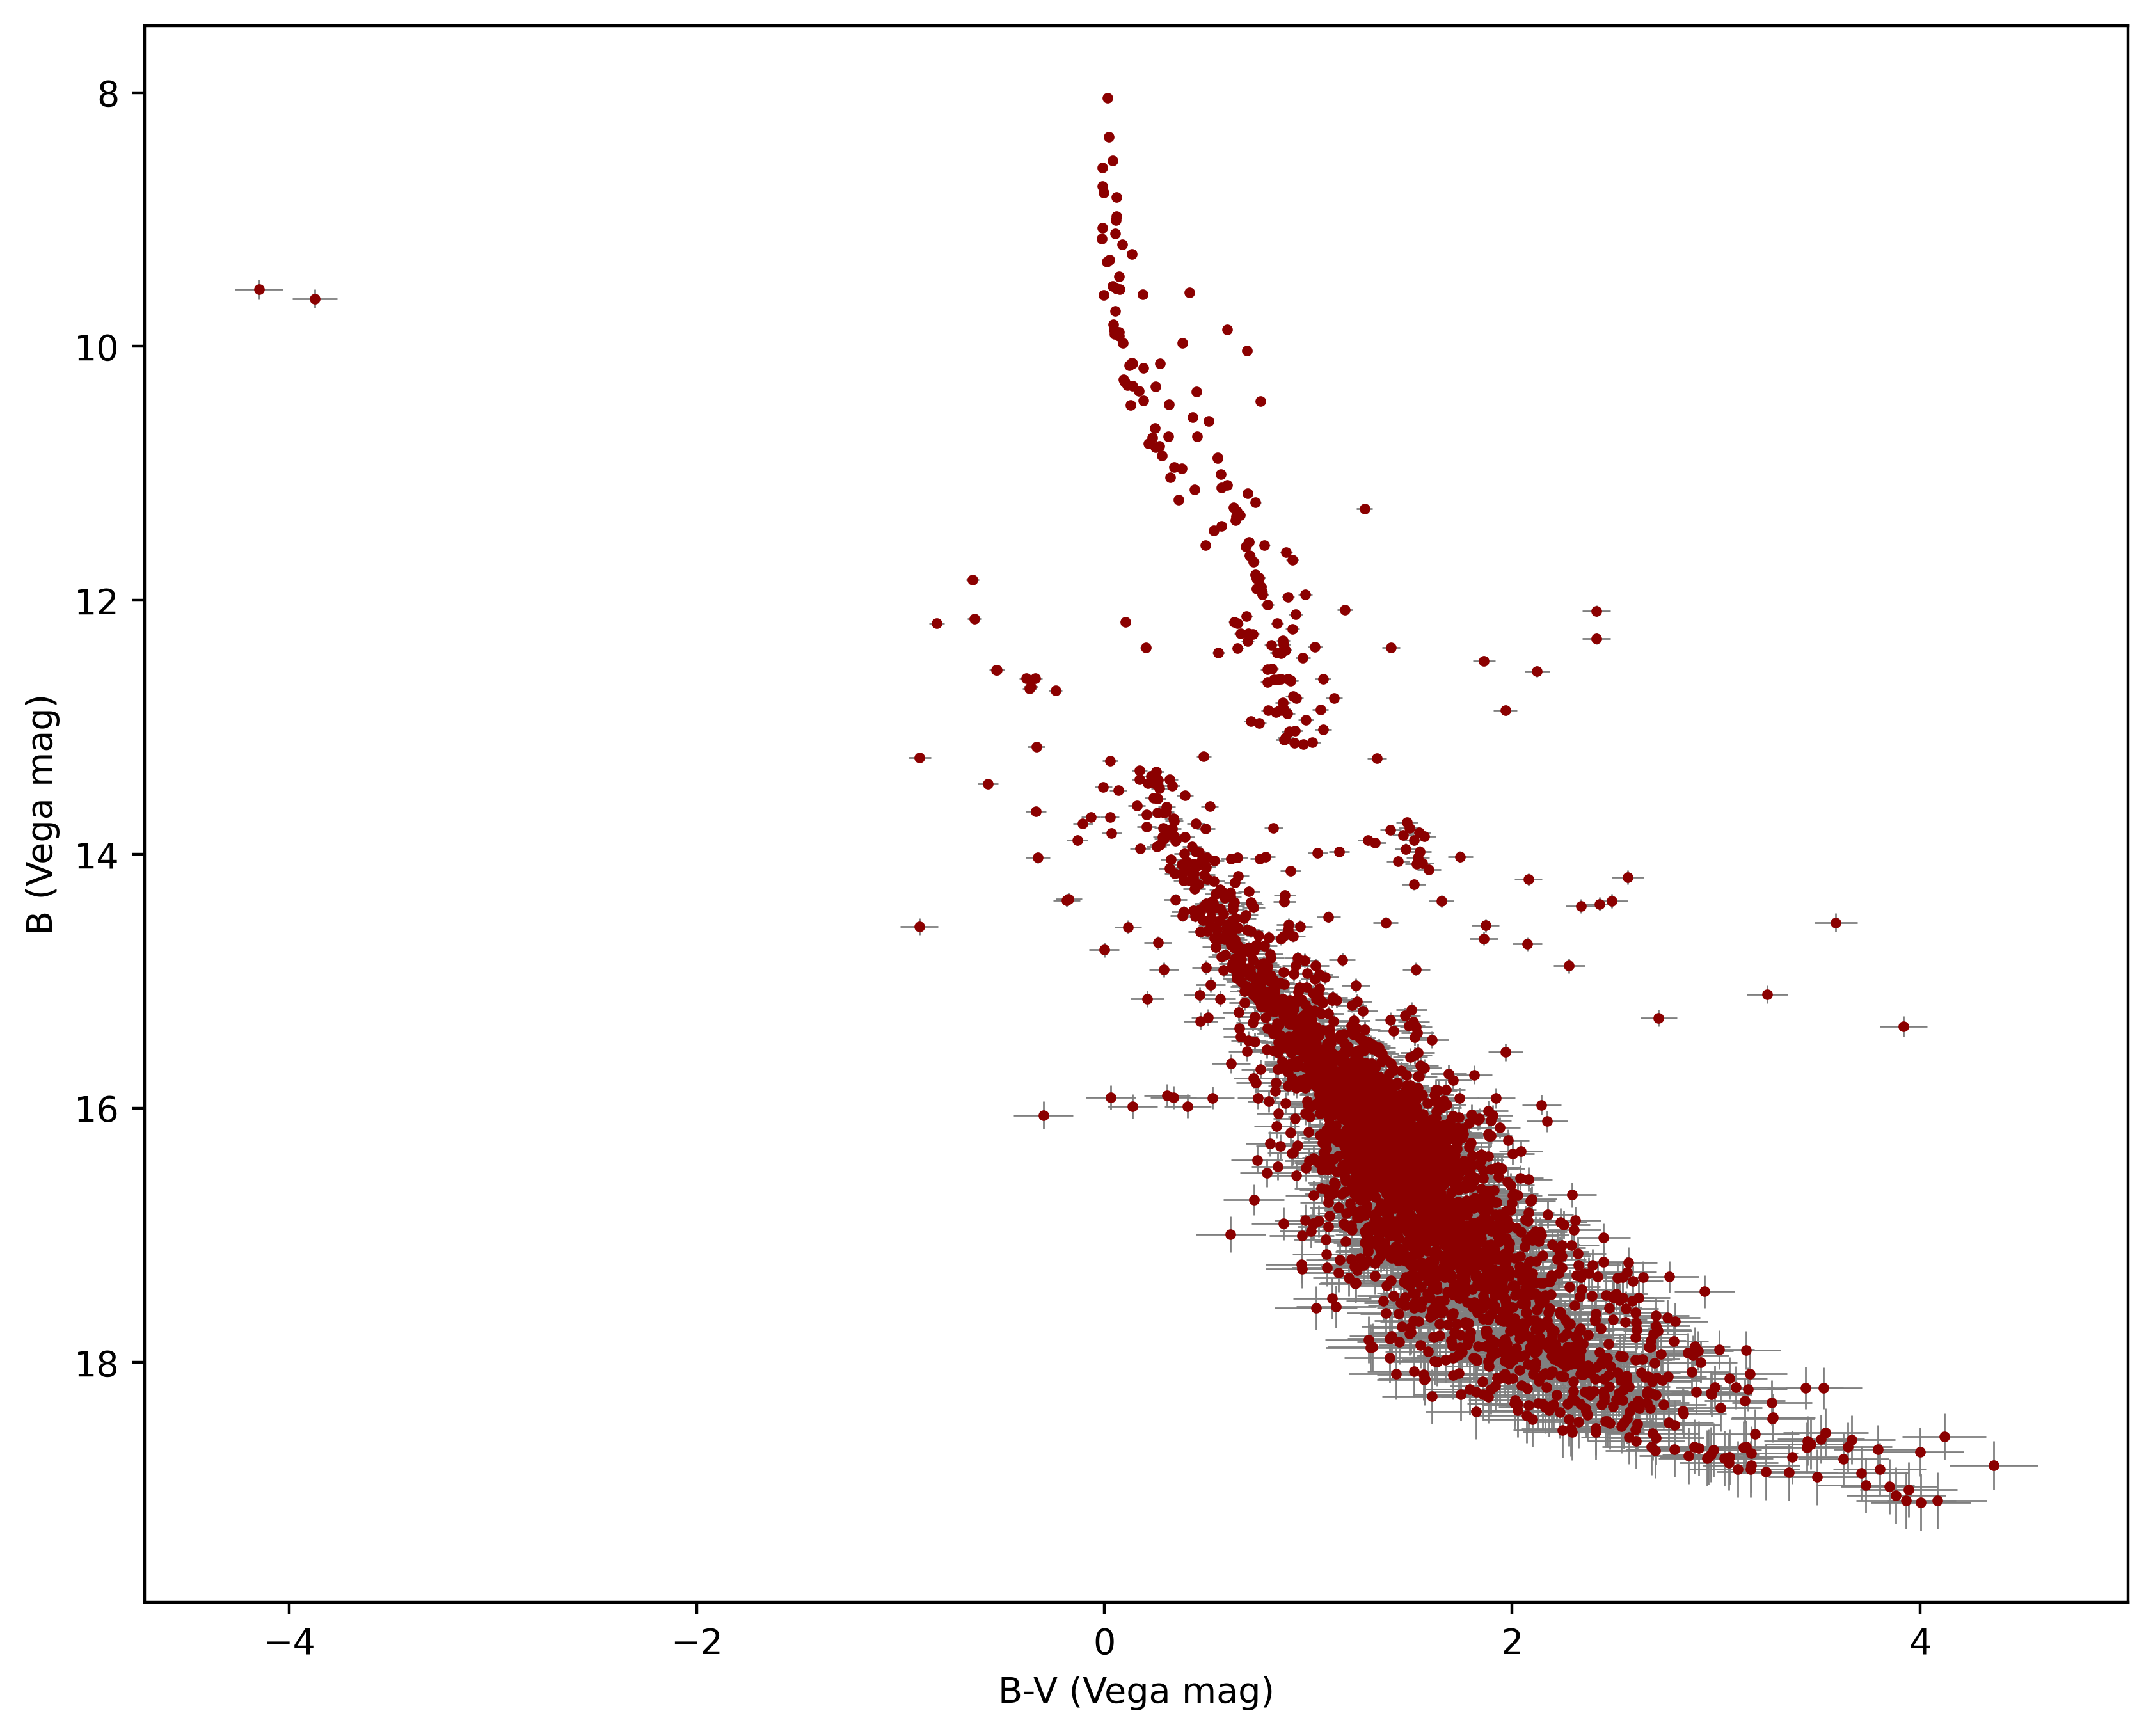

In [296]:
V = [i['V_mag_ob'] for i in final]
V_err = [i['V_mag_ob_err'] for i in final]
B = [i['B_mag_ob'] for i in final]
B_err = [i['B_mag_ob_err'] for i in final]
BV = [i['B_mag_ob'] - i['V_mag_ob'] for i in final]
BV_err = [(i['B_mag_ob_err'] ** 2 + i['V_mag_ob_err'] ** 2) ** (1 / 2) for i in final]

plot_color_diagram(x = BV, y = B, x_label = "B-V (Vega mag)", y_label = "B (Vega mag)", data_s = 2, data_c = "darkred", err = [BV_err , B_err], err_c = "gray", save = "D:/AAO_data/BV_B.jpg")

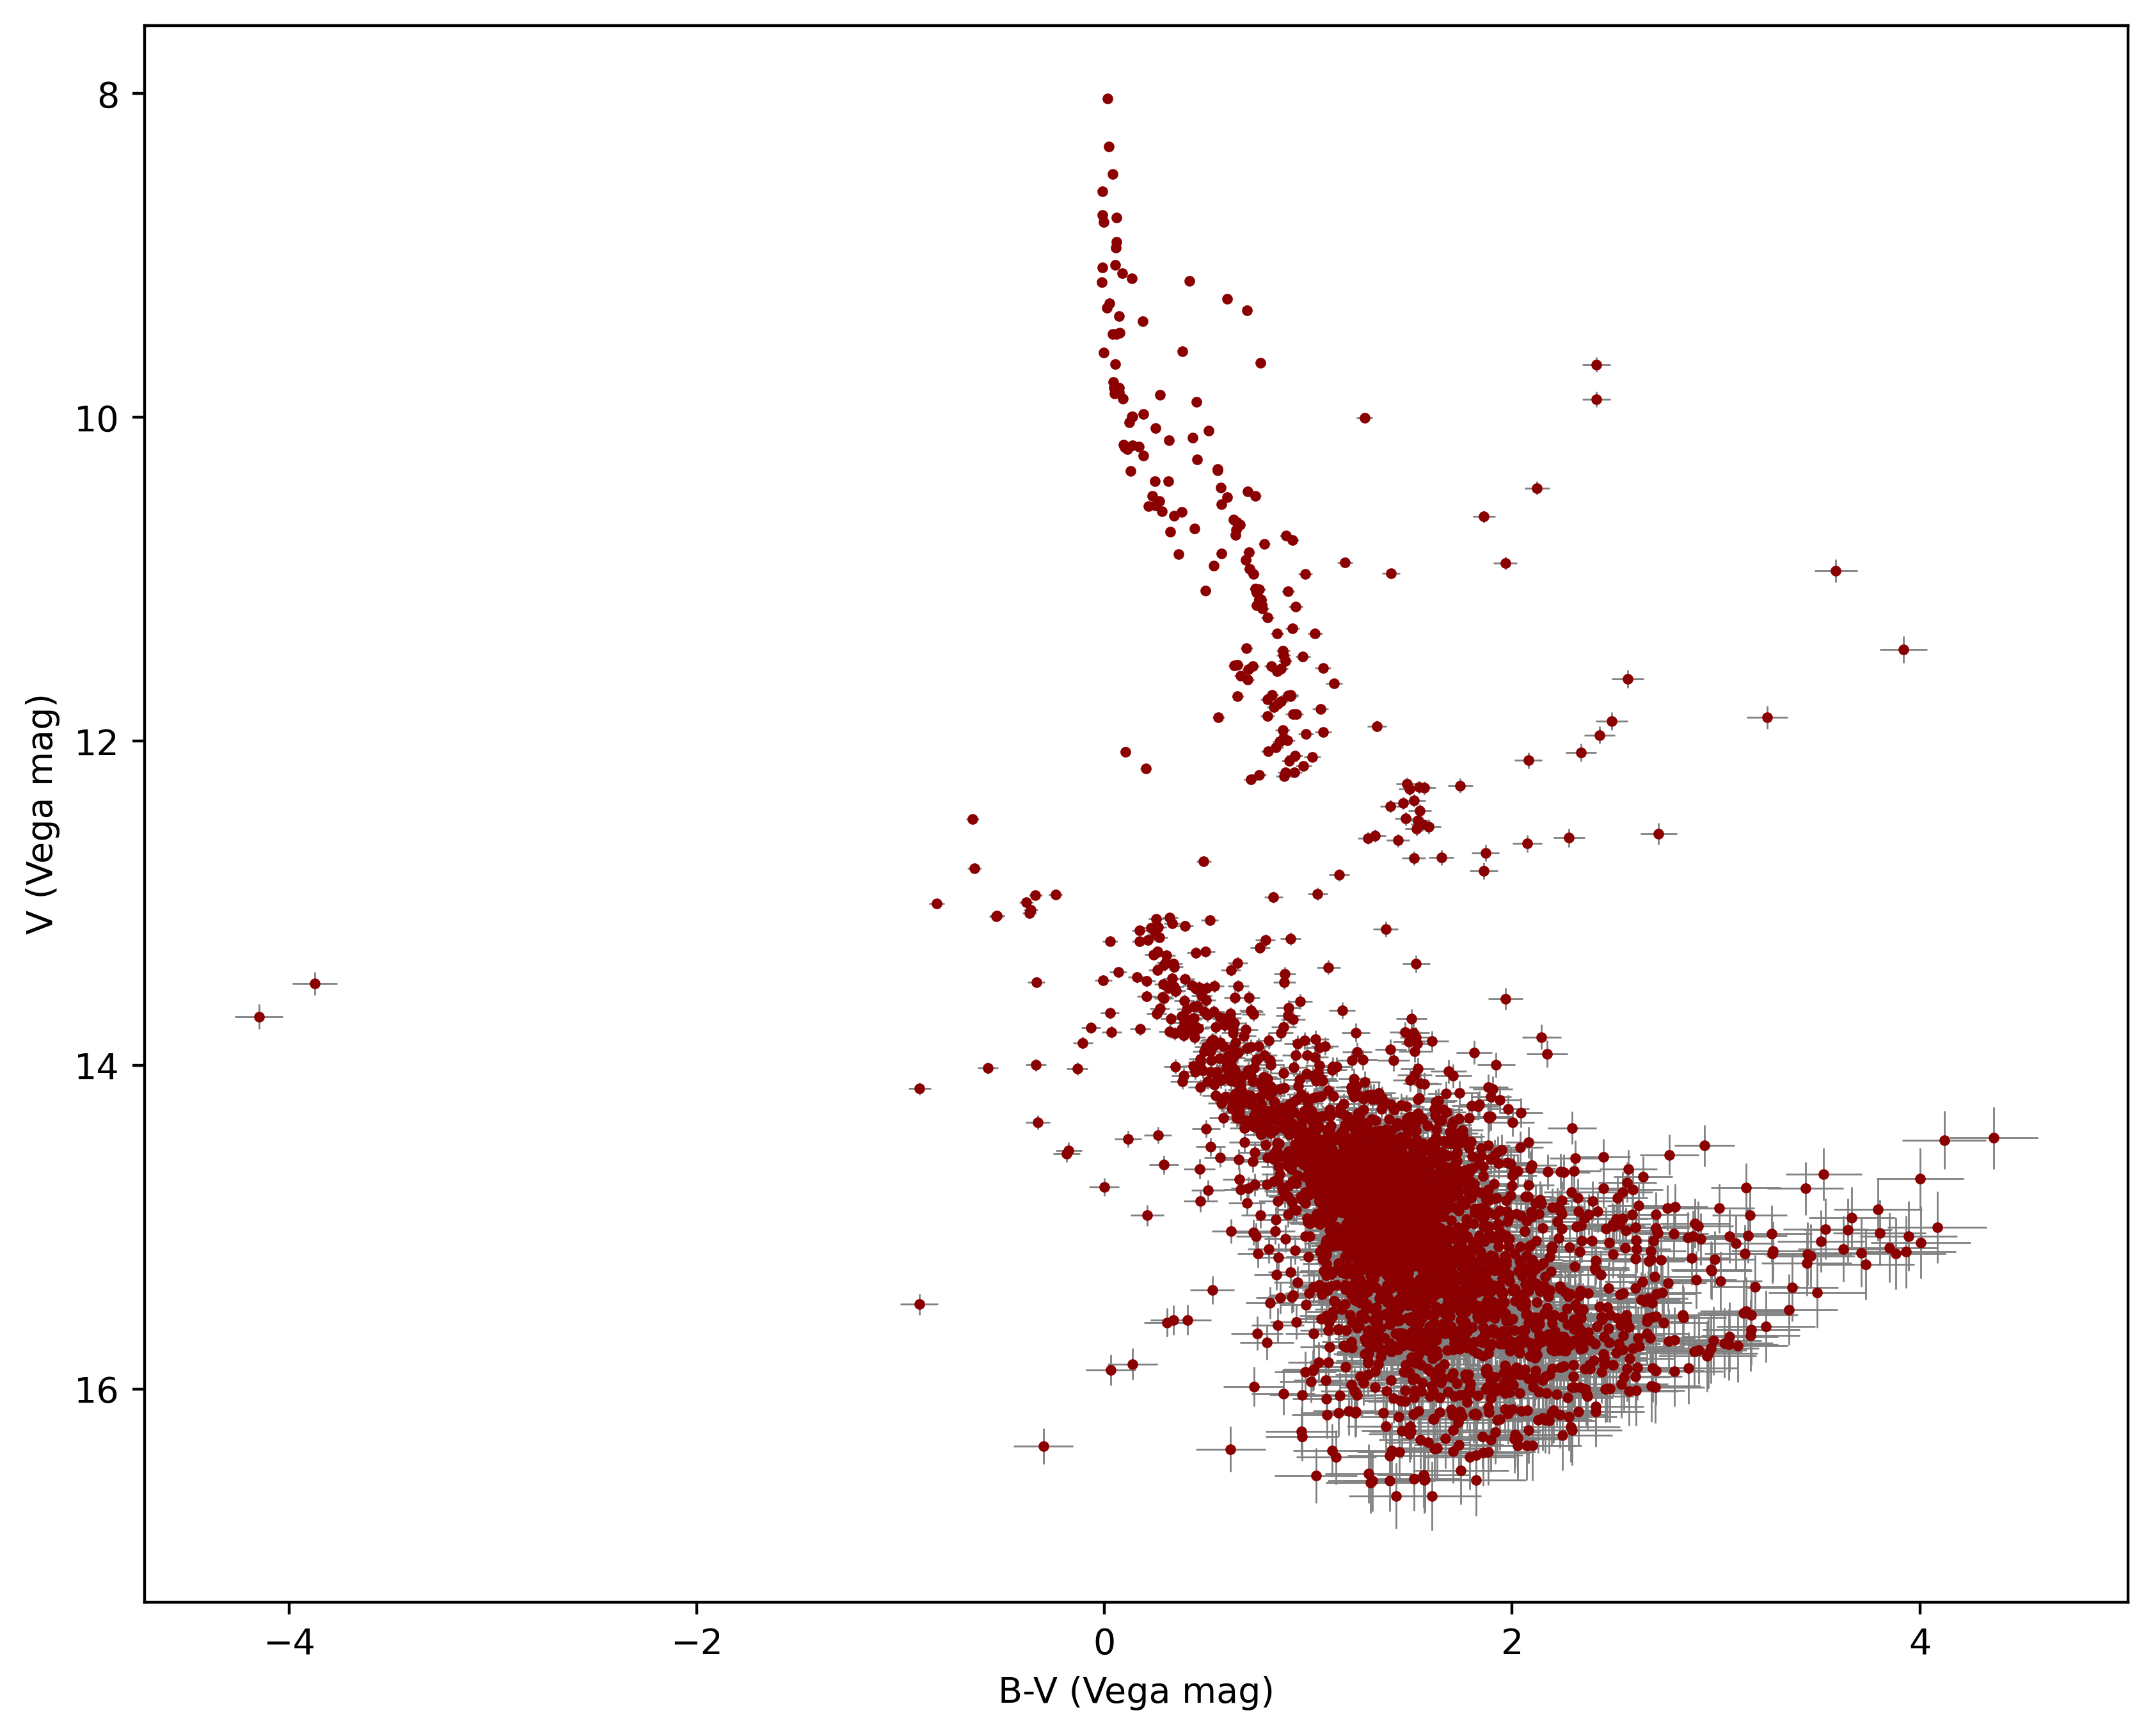

In [295]:
plot_color_diagram(x = BV, y = V, x_label = "B-V (Vega mag)", y_label = "V (Vega mag)", data_s = 2, data_c = "darkred", err = [BV_err , B_err], err_c = "gray", save = "D:/AAO_data/BV_V.jpg")